# Platform for Live Crypto Trading with ML

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.5 MB/s 
     |████████████████████████████████| 70 kB 9.7 MB/s 
     |████████████████████████████████| 112 kB 90.4 MB/s 
     |████████████████████████████████| 288 kB 78.5 MB/s 
     |████████████████████████████████| 1.1 MB 68.4 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 74.5 MB/s 
     |████████████████████████████████| 144 kB 97.3 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [5]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [6]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [7]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [8]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (168345, 8)


In [9]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:01:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:16:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:31:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:46:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:01:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1654949700,1654949700,28778.53,28806.75,28700.00,28786.39,558.714510,10570.0,2022-06-11 12:16:00,2022-06-11 12:30:00
1654950600,1654950600,28786.39,28786.39,28667.29,28733.14,662.848030,12283.0,2022-06-11 12:31:00,2022-06-11 12:45:00
1654951500,1654951500,28733.14,28733.64,28479.60,28479.61,1657.133970,24967.0,2022-06-11 12:46:00,2022-06-11 13:00:00


#  "Wick Candles"

---

# Data Exploration


In [10]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:01:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:16:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:31:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:46:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:01:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-06-11 12:16:00,28700.00,28806.75,28778.53,28786.39,558.714510
2022-06-11 12:31:00,28667.29,28786.39,28786.39,28733.14,662.848030
2022-06-11 12:46:00,28479.60,28733.64,28733.14,28479.61,1657.133970


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

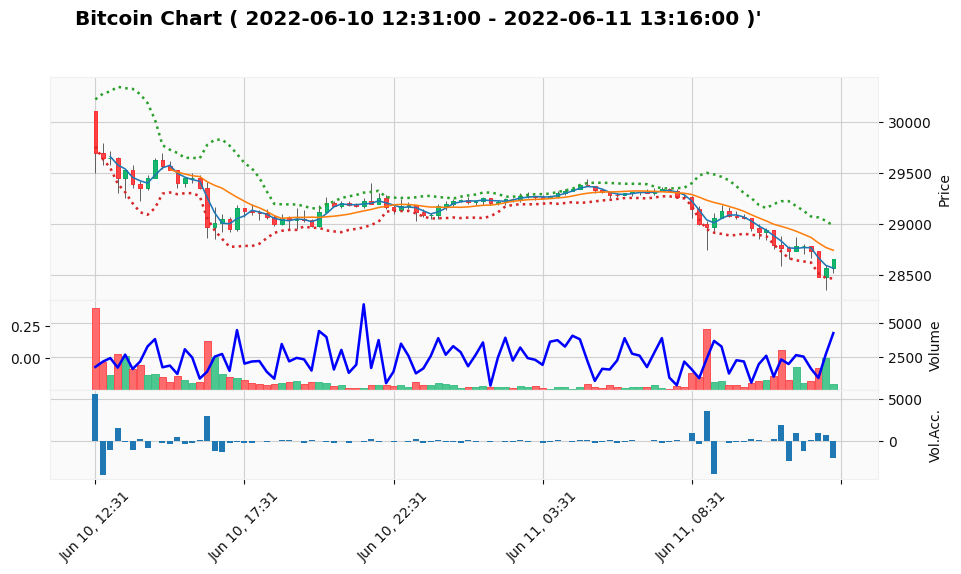

In [11]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

# Generate timeseries

In [12]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [13]:
ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

[0.4378011772578906,
 0.4364649485803254,
 0.43623368523602074,
 0.43594333137578933,
 0.43634858851968705,
 0.4364202437369972,
 0.4359354101510041,
 0.43362705599031254,
 0.43437265265429326,
 0.4351876283215654]

In [14]:
btc_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.9)

In [15]:
btc_model.sats2model()
btc_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       896         ['Candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2048        ['Candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       3776        ['Candles[0][0]']                
                                                                                              

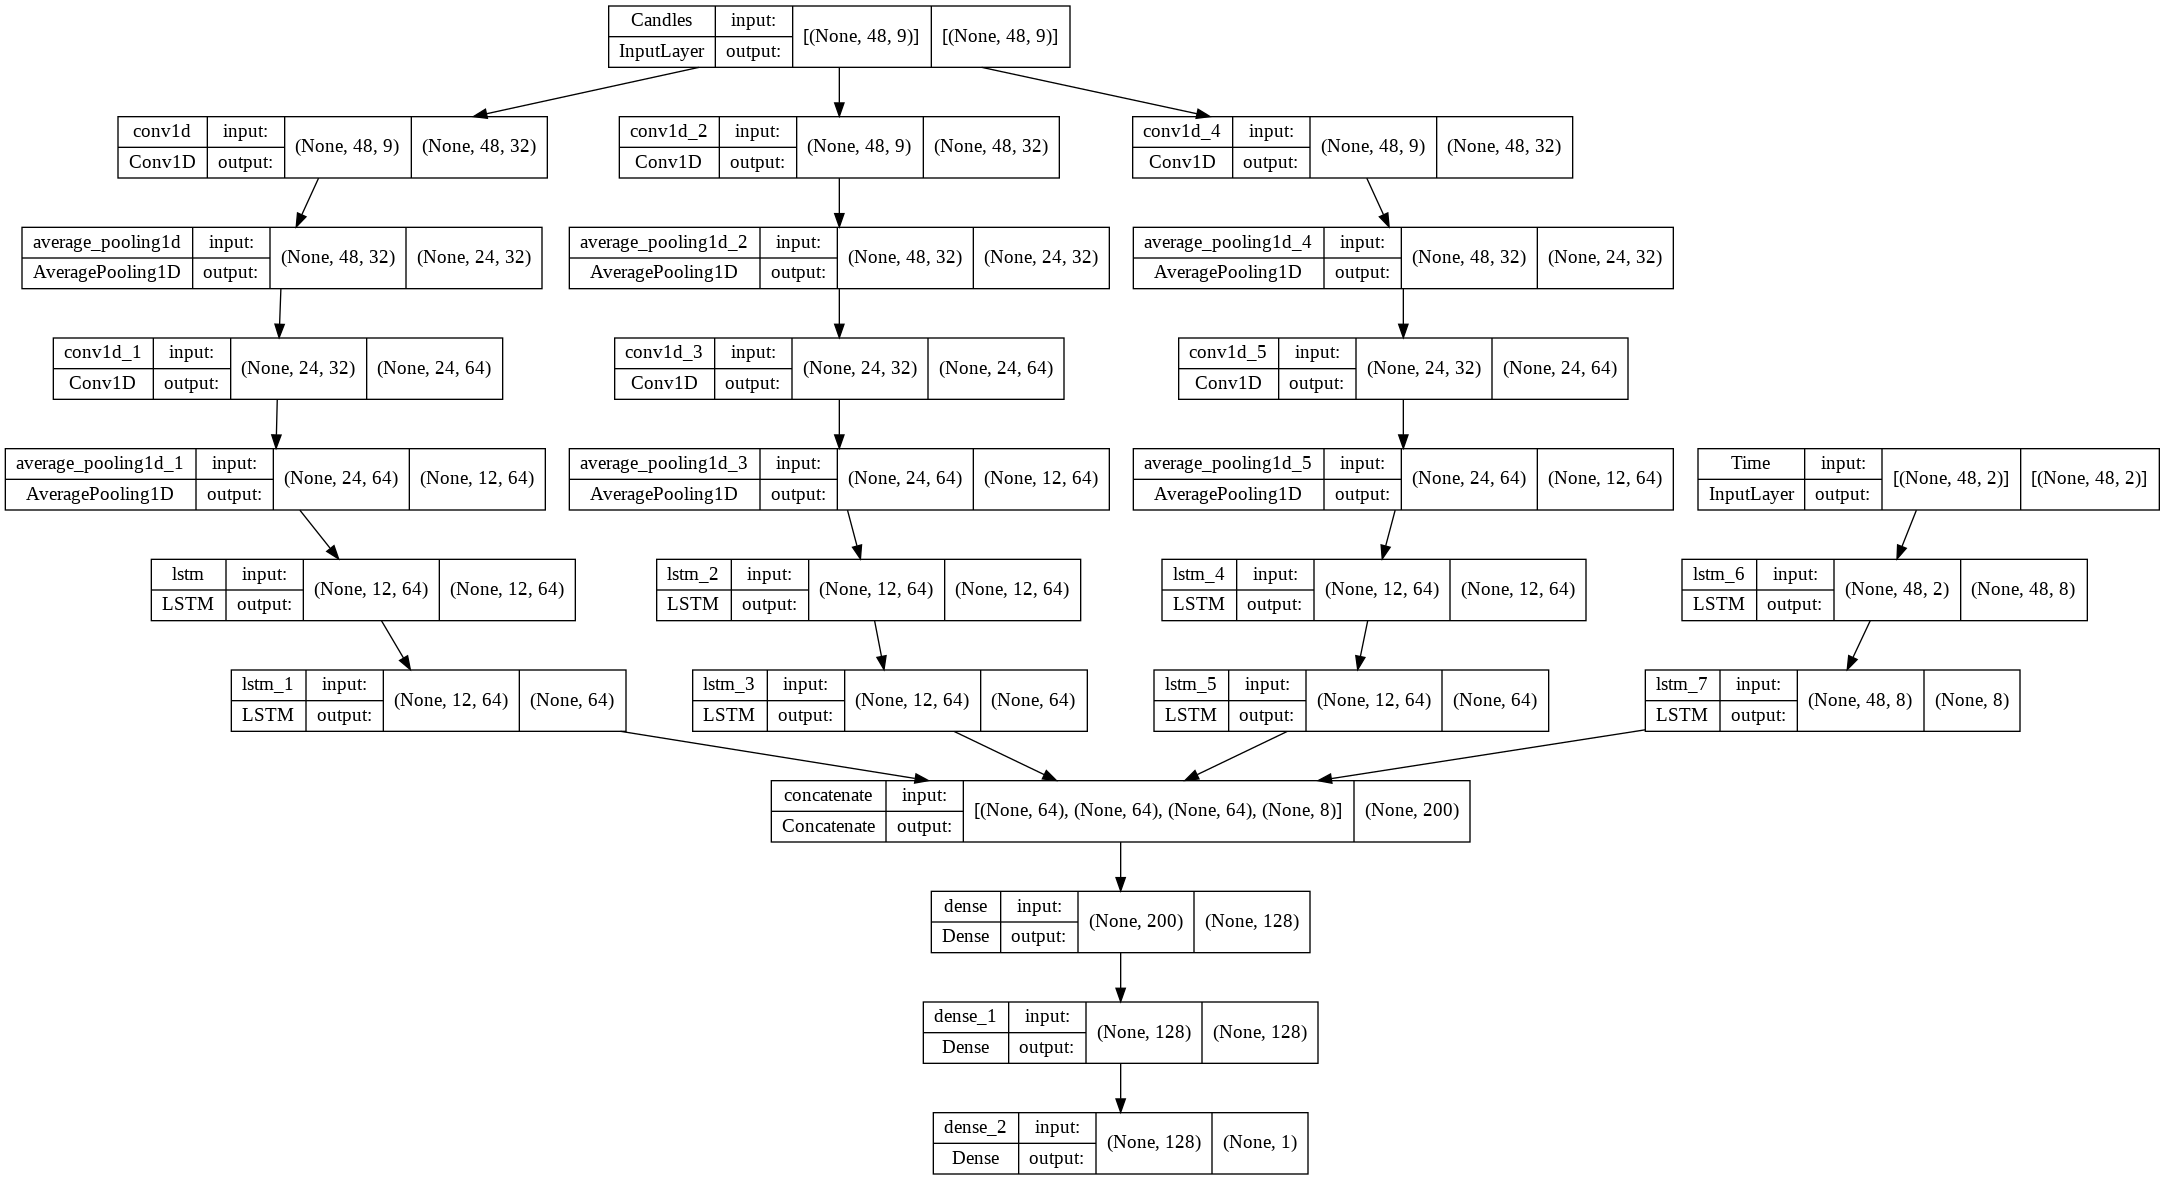

In [16]:
keras.utils.plot_model(btc_model.model, "conv_lstm_net.png", show_shapes=True)

In [17]:
btc_model.sats2train()

Epoch 1/20
11/11 [==============================] - 28s 477ms/step - loss: 0.2045 - val_loss: 0.1269
Epoch 2/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0549 - val_loss: 0.0537
Epoch 3/20
11/11 [==============================] - 1s 104ms/step - loss: 0.0371 - val_loss: 0.0562
Epoch 4/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0202 - val_loss: 0.0316
Epoch 5/20
11/11 [==============================] - 1s 93ms/step - loss: 0.0305 - val_loss: 0.0242
Epoch 6/20
11/11 [==============================] - 1s 94ms/step - loss: 0.0207 - val_loss: 0.0081
Epoch 7/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0170 - val_loss: 0.0187
Epoch 8/20
11/11 [==============================] - 1s 93ms/step - loss: 0.0172 - val_loss: 0.0170
Epoch 9/20
11/11 [==============================] - 1s 105ms/step - loss: 0.0169 - val_loss: 0.0066
Epoch 10/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0160 - val_loss: 0.0097
E

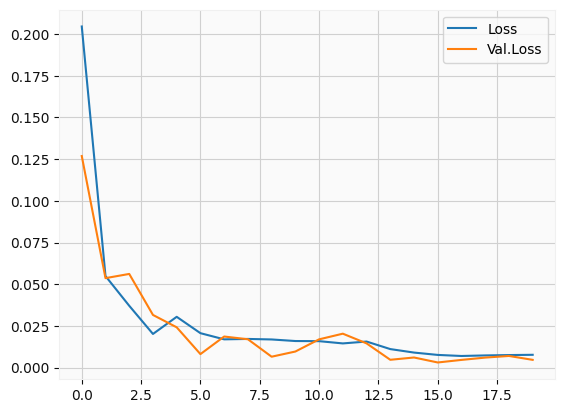

In [18]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [19]:
btc_model.sats2pred()

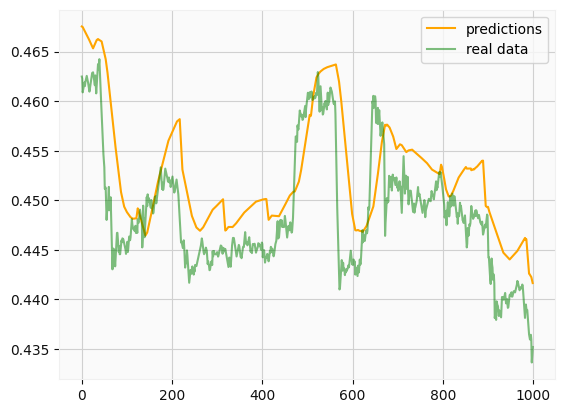

In [20]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [37]:
btc_model.preds.shape

(4996, 1)

In [43]:
ts_btc.candles.values.shape

(168335, 9)

In [59]:
def denorm(values,scaler,candles):

        example = candles.values[-len(values):,:].copy()
        example[:,-1] = values.squeeze().copy()
        scaled_val = [scaler.inverse_transform(np.array([to_scale]))[0][-1] for to_scale in example ] 
        return scaled_val
        
len(denorm(btc_model.preds,ts_btc.scaler,ts_btc.candles))


4996

29360.029482123246

In [26]:
ts_btc.denorm(btc_model.preds[-1][0])

29360.029482123246

Fee: 0.025
----------------------
Buy      2844 ( 1583 ok 1261 ko )
No-op    2152
Wallet   36019.06500000008
Drawback -1132.0202499999998
Total earned 36019.06500000008


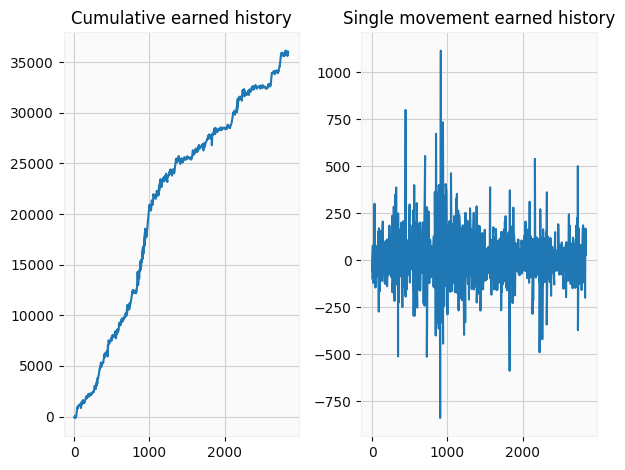

In [ ]:
total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(btc_model.preds, btc_model.split_point, fee=0.025)

print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [65]:
len(ts_btc.x_candles)

49952

In [ ]:
preds_old = btc_model.preds
y_test_old = btc_model.y_test

In [ ]:
btc_model.sats2train(epochs = 100)

Epoch 1/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0079 - val_loss: 0.0041
Epoch 2/100
11/11 [==============================] - 1s 96ms/step - loss: 0.0077 - val_loss: 0.0094
Epoch 3/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0081 - val_loss: 0.0051
Epoch 4/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 5/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0079 - val_loss: 0.0034
Epoch 6/100
11/11 [==============================] - 1s 97ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 7/100
11/11 [==============================] - 1s 100ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 8/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0077 - val_loss: 0.0065
Epoch 9/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0078 - val_loss: 0.0032
Epoch 10/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0075 - val_loss: 0.00

In [ ]:
btc_model.sats2pred()

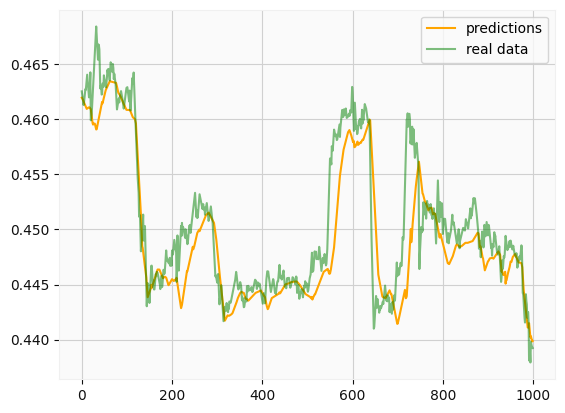

In [ ]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [ ]:
btc_model.split_point

44956

Fee: 0.025
----------------------
Buy      204 ( 125 ok 79 ko )
No-op    4792
Wallet   8598.567999999976
Drawback -604.422000000004
Total earned 8598.567999999976


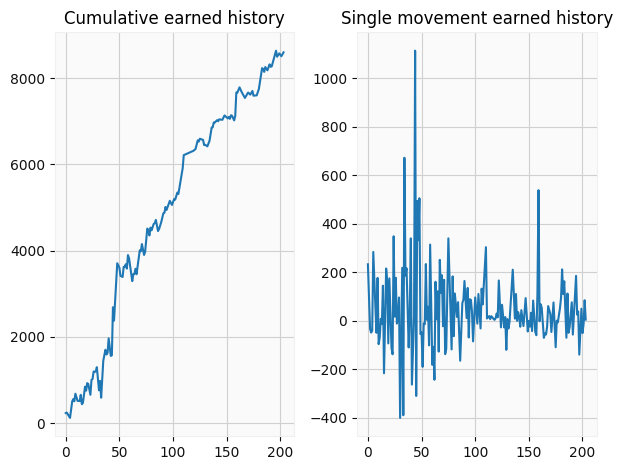

In [ ]:
total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(btc_model.preds, btc_model.split_point, fee=0.025)

print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [ ]:
df_pred_exp = pd.DataFrame(np.array([np.squeeze(preds),np.squeeze(y_test)]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = log_return(df_pred_exp["Predicted"],periods=-1)


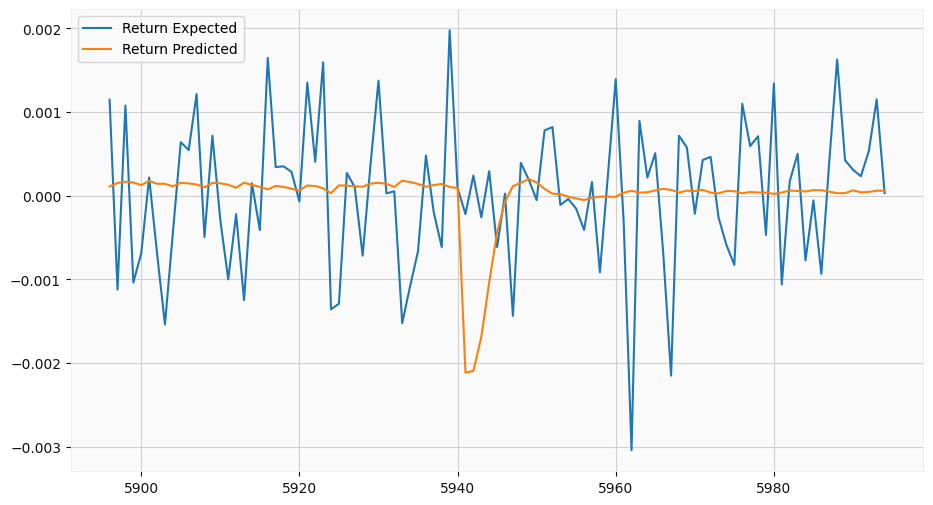

In [ ]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-100:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-100:].plot(y="Return Predicted",ax=axs)

In [ ]:
len(can_btc.candles_norm[0])
can_btc.candles

,Low,High,Open,Close,Volume,UpperBB,LowerBB,price2volratio,vol_diff
Date,,,,,,,,,
2017-08-17 06:31:00,4319.83,4345.45,4328.65,4345.45,3.494176,4354.619977,4264.944023,4.808001,-0.006737
2017-08-17 06:46:00,4324.35,4345.45,4345.45,4324.35,0.169238,4345.916804,4286.227196,-124.676491,-3.324938
2017-08-17 07:01:00,4316.62,4316.62,4316.62,4316.62,0.001541,4346.272361,4287.181639,0.000000,-0.167697
2017-08-17 07:16:00,4291.38,4291.38,4291.38,4291.38,0.038918,4348.406850,4281.557150,0.000000,0.037377
2017-08-17 07:31:00,4291.39,4300.00,4291.39,4300.00,0.718901,4348.690957,4280.411043,11.976614,0.679983
...,...,...,...,...,...,...,...,...,...
2022-06-05 14:46:00,29752.87,29837.86,29776.51,29791.71,286.305150,29809.313016,29637.404984,0.053090,115.637360
2022-06-05 15:01:00,29781.70,29829.65,29791.72,29803.15,223.742310,29831.428763,29633.997237,0.051086,-62.562840
2022-06-05 15:16:00,29788.39,29879.00,29803.15,29829.20,330.354340,29858.883772,29628.784228,0.078855,106.612030


In [ ]:
def denorm(value,scaler):
    example = [0.5 for x in range(9)]
    example[-1] = value
    return scaler.inverse_transform([example])[0][-1]

In [ ]:
def backtesting(fee=0.025):
    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0

    for i in range(split_point, len(x_candles)):
        prediction = preds[i - split_point][0]
        predicted_close = denorm(prediction)
        previous_close = denorm(candles_norm[i][3])
        real_next_close = denorm(candles_norm[i+1][3])

        if (previous_close + (previous_close * fee)) < predicted_close:  # buy
            profit = real_next_close - previous_close
            if profit > 0:
                profit = profit - (profit * fee)
                buys_cnt_win += 1
                old_profit_negative = False
            else:
                profit = profit + (profit * fee)
                buys_cnt_losses += 1
                if old_profit_negative:
                    old_profits += profit
                else:
                    old_profits = profit
                if old_profits < drawback:
                    drawback = old_profits
                old_profit_negative = True
            wallet += profit
            total_wallet_history.append(wallet)
            single_wallet_history.append(profit)
            buys_cnt += 1
        else:
            old_profit_negative = False
            old_profits = 0

    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('No-op   ', (len(x_candles) - split_point) - buys_cnt)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    return total_wallet_history, single_wallet_history, wallet

total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

NotFittedError: ignored

Total earned 3782.9209999999875


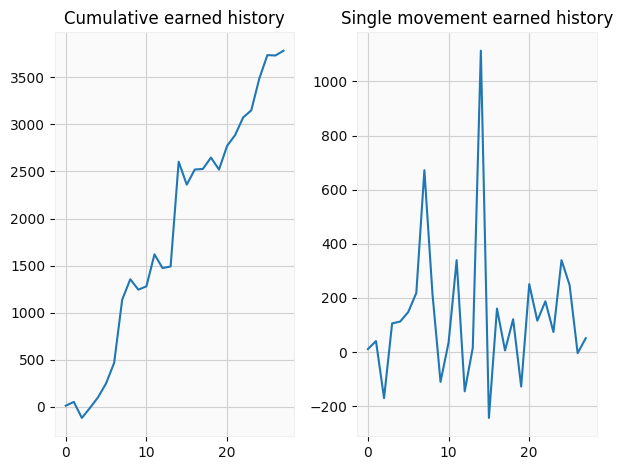

In [ ]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

## training on more epochs

In [ ]:
preds_old = preds
y_test_old = y_test

In [ ]:
many_epochs = 50
print(f'training on {many_epochs} epochs...')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    [x_train_candles, x_train_time], 
    y_train, 
    epochs=many_epochs,
    initial_epoch=21, 
    batch_size=4096,
    validation_data=([x_test_candles, x_test_time], y_test),
    callbacks=model_checkpoint_callback,
    verbose=1
)

training on 50 epochs...
Epoch 22/50
14/14 [==============================] - 1s 98ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 23/50
14/14 [==============================] - 1s 95ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 24/50
14/14 [==============================] - 1s 84ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 25/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0065 - val_loss: 0.0080
Epoch 26/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 27/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 28/50
14/14 [==============================] - 1s 84ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 29/50
14/14 [==============================] - 1s 84ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 30/50
14/14 [==============================] - 1s 84ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 31/50
14/14 [==============================] - 1s 85ms/step - loss: 0

In [ ]:
model.load_weights('weights/weights')

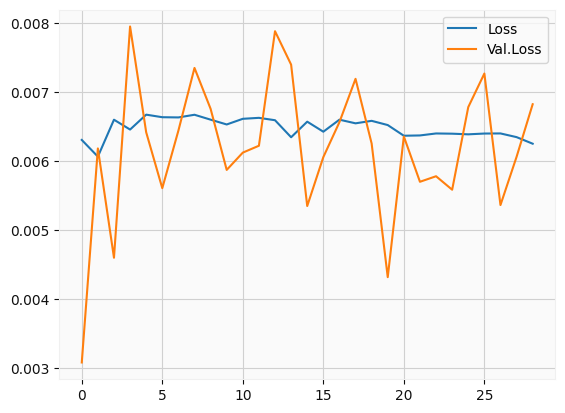

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
preds = model.predict([x_test_candles, x_test_time], batch_size=4096)

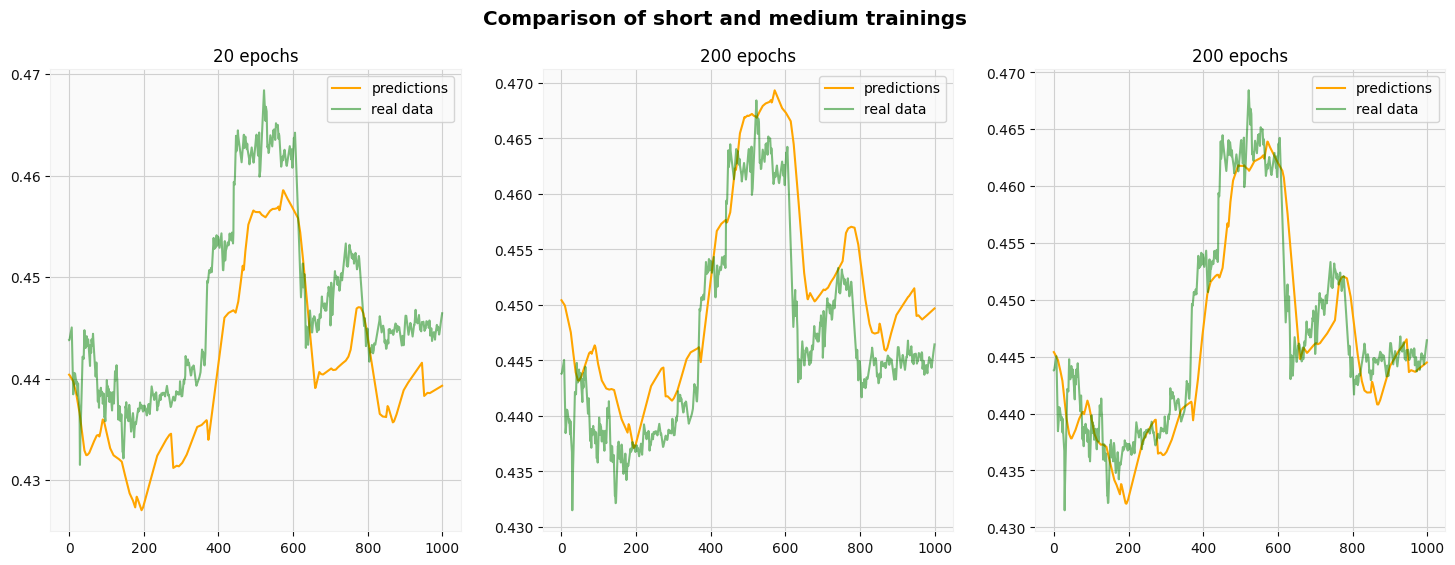

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.suptitle('Comparison of short and medium trainings')

ax1.set_title('20 epochs')
ax1.plot(preds_old[-1000:], color='orange', label='predictions')
ax1.plot(y_test_old[-1000:], color='green', alpha=0.5, label='real data')
ax1.legend()

ax2.set_title('200 epochs')
ax2.plot(preds[-1000:], color='orange', label='predictions')
ax2.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
ax2.legend()

ax3.set_title('200 epochs')
ax3.plot((preds[-1000:]+preds_old[-1000:])/2, color='orange', label='predictions')
ax3.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
ax3.legend()


plt.show()

In [ ]:
df_pred_exp = pd.DataFrame(np.array([np.squeeze(preds),np.squeeze(y_test)]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = log_return(df_pred_exp["Predicted"],periods=-1)


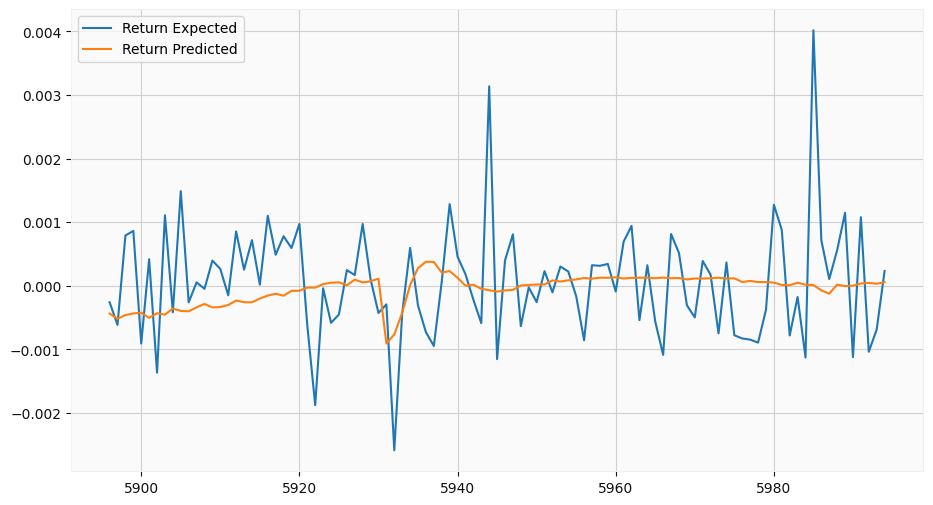

In [ ]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-100:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-100:].plot(y="Return Predicted",ax=axs)

In [ ]:
total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

Fee: 0.025
----------------------
Buy      203 ( 134 ok 69 ko )
No-op    5793
Wallet   11698.86549999998
Drawback -604.422000000004


Total earned 11698.86549999998


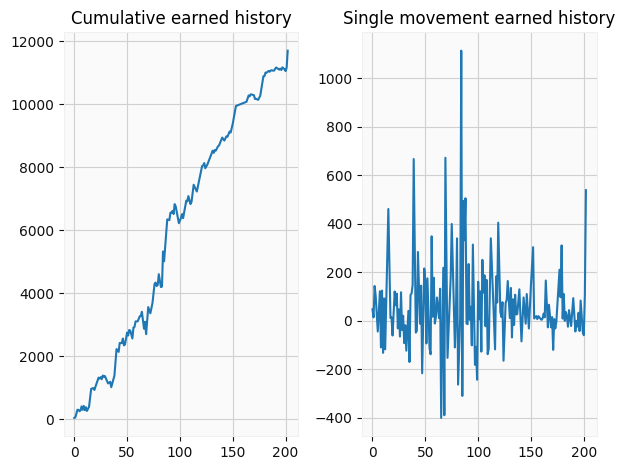

In [ ]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()